## 1. Evaluate the model on the inference.csv predictions using inference_labels.csv
## 2. Compare results to performance on test.csv.

In [1]:
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer
from imu_pipeline import IMUPipeline
from pathlib import Path
import pandas as pd
import joblib
import os
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

In [3]:
from extract_features import process_dataset
process_dataset('inference')

[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


100%|████████████████████████████████████████| 473/473 [00:02<00:00, 202.83it/s]

Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,2.578586,2.362892,8.999561,-5.200753,14.200314,0.193760,1.400440,31,1223.236383,2.995496,...,12,49,996,S603575,v1.3.0,ok,79,5.570705,4g,model_c
1,-0.114423,2.185548,10.289834,-5.283784,15.573618,2.164783,7.702143,5,478.971240,0.343485,...,22,75,607,S949312,v1.2.4,ok,81,3.181146,4g,model_c
2,0.061702,0.147340,0.291371,-0.208436,0.499806,-0.407912,-1.211002,15,2.551629,0.015451,...,30,52,482,S223545,v1.2.3,recent,95,2.987759,4g,model_b
3,1.354891,2.486652,11.114359,-6.365416,17.479775,0.764660,3.152818,15,801.916607,1.424555,...,11,36,463,S993755,v1.2.3,pending,47,9.744692,4g,model_a
4,0.061687,0.141320,0.278571,-0.246872,0.525443,-0.440889,-1.157643,17,2.377675,0.018567,...,13,41,759,S734746,v1.2.4,recent,37,3.622219,wifi,model_a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,0.060402,0.141580,0.300225,-0.230982,0.531207,-0.394775,-1.216041,14,2.369336,0.015395,...,15,57,750,S165342,v1.2.4,ok,54,9.761510,4g,model_c
469,0.159769,2.509925,8.347333,-9.574540,17.921873,0.287556,3.356591,10,632.524802,1.805974,...,12,76,900,S653588,v1.3.0,pending,23,8.203065,4g,model_a
470,-0.548699,2.591718,6.550702,-8.426525,14.977227,-0.191147,1.450593,11,701.807315,1.414847,...,22,77,11,S945979,v1.3.0,pending,80,5.033353,5g,model_b
471,-0.559437,1.851954,4.829766,-6.744202,11.573968,-0.103196,1.832355,9,374.270158,1.994104,...,29,50,831,S424057,v1.3.0,pending,83,1.703700,5g,model_c


In [4]:
import pandas as pd
labels = pd.read_csv("data/manual_annotation/inference_labels.csv")

In [5]:
import joblib
from imu_pipeline import IMUPipeline

df_inf = pd.read_csv("data/inference.csv")
model = joblib.load("models/imu_pipeline.pkl")

preds = model.predict(df_inf)
probs = model.predict_proba(df_inf)

Validation of threshold 0.5 and pred = 'collision' if prob[0] > 0.5:

In [6]:
(['collision' if prob[0] > prob[1] else 'normal' for prob in probs] == preds).all()

True

In [7]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

X_inf = pd.read_csv('data/inference.csv')
y_inf = pd.read_csv('data/manual_annotation/inference_labels.csv')

In [8]:
df_train['label'].sample(5)

379       normal
544    collision
387       normal
388       normal
148       normal
Name: label, dtype: object

Reorder columns so the target is at the end:

In [9]:
target_column = df_train.pop('label')
last_index = len(df_train.columns)
df_train.insert(last_index, 'label', target_column)

target_column = df_test.pop('label')
last_index = len(df_test.columns)
df_test.insert(last_index, 'label', target_column)

In [10]:
df_train.head(2)

,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model,label
0,0.057289,0.140447,0.265758,-0.214983,0.480742,-0.388161,-1.292653,17,2.300756,0.014241,...,46,409,S607704,v1.2.3,recent,93,6.111424,5g,model_c,normal
1,0.058397,0.147305,0.315987,-0.237875,0.553862,-0.371543,-1.247677,12,2.510906,0.015394,...,34,632,S513749,v1.3.0,recent,94,5.448867,wifi,model_c,normal


In [11]:
df_inf.head(2)

,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,2.578586,2.362892,8.999561,-5.200753,14.200314,0.193760,1.400440,31,1223.236383,2.995496,...,12,49,996,S603575,v1.3.0,ok,79,5.570705,4g,model_c
1,-0.114423,2.185548,10.289834,-5.283784,15.573618,2.164783,7.702143,5,478.971240,0.343485,...,22,75,607,S949312,v1.2.4,ok,81,3.181146,4g,model_c


In [12]:
X_train = df_train.drop(columns=['label'])
y_train = df_train['label']

X_test = df_test.drop(columns=['label'])
y_test = df_test['label']

df_inf = X_inf.merge(y_inf, on='sample_id', how='inner')
y_inf = df_inf['label']

In [13]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_inf_pred = model.predict(X_inf)

### Let's analyze the model's performance across the sets:

In [14]:
print(f'Train:\n{classification_report(y_train, y_train_pred)}\n\n')
print(f'Test:\n{classification_report(y_test, y_test_pred)}\n\n')
print(f'Inference:\n{classification_report(y_inf, y_inf_pred)}\n\n')

Train:
              precision    recall  f1-score   support

   collision       1.00      1.00      1.00       400
      normal       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



Test:
              precision    recall  f1-score   support

   collision       1.00      0.89      0.94       100
      normal       0.90      1.00      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



Inference:
              precision    recall  f1-score   support

   collision       0.59      0.96      0.73       236
      normal       0.89      0.33      0.48       237

    accuracy                           0.64       473
   macro avg       0.74      0.65      0.61       473
weighted avg       0.74      0.64      0.61   

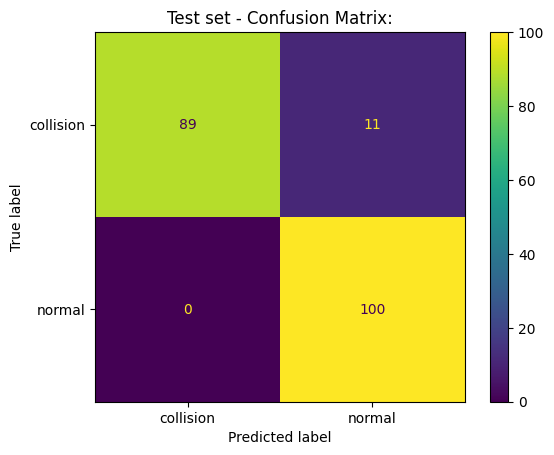

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title('Test set - Confusion Matrix:')
plt.show()

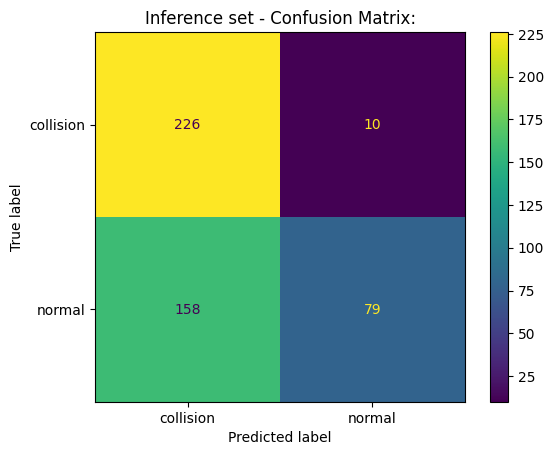

In [16]:
ConfusionMatrixDisplay.from_predictions(y_inf, y_inf_pred)
plt.title('Inference set - Confusion Matrix:')
plt.show()

We see that there's a big difference in performance between the test and the inference sets. We'll do some exploratory analysis to get insights of why this happens.

## 3. Perform EDA to understand dataset differences


In [17]:
if set(df_train.columns) == set(df_test.columns) == set(df_inf.columns):
    print('All sets have the same columns.')
else:
    print('Columns in the sets differ.')

All sets have the same columns.


In [18]:
print(f'Train set has missing values: {df_train.isna().sum().sort_values(ascending=False).any()}')
print(f'Test set has missing values: {df_test.isna().sum().sort_values(ascending=False).any()}')
print(f'Inference set has missing values: {X_inf.isna().sum().sort_values(ascending=False).any()}')

Train set has missing values: False
Test set has missing values: False
Inference set has missing values: False


In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   x_mean               200 non-null    float64
 1   x_std                200 non-null    float64
 2   x_max                200 non-null    float64
 3   x_min                200 non-null    float64
 4   x_range              200 non-null    float64
 5   x_skew               200 non-null    float64
 6   x_kurtosis           200 non-null    float64
 7   x_n_peaks            200 non-null    int64  
 8   x_energy             200 non-null    float64
 9   y_mean               200 non-null    float64
 10  y_std                200 non-null    float64
 11  y_max                200 non-null    float64
 12  y_min                200 non-null    float64
 13  y_range              200 non-null    float64
 14  y_skew               200 non-null    float64
 15  y_kurtosis           200 non-null    flo

In [20]:
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_inf['timestamp'] = pd.to_datetime(df_inf['timestamp'])

In [21]:
# Get some insights on when are the samples from
print(f"Mean of sets:\nTrain: {df_train['timestamp'].mean()}\nTest: {df_test['timestamp'].mean()}\nInference: {df_inf['timestamp'].mean()}")

Mean of sets:
Train: 2025-05-25 14:34:54.586582784
Test: 2025-05-25 14:34:55.627961344
Inference: 2025-05-25 14:34:56.293260800


In [22]:
df_inf.shape

(473, 61)

In [23]:
# Concatenate all dataframes into one in order to check if there are duplicate values
df = pd.concat([df_train, df_test, df_inf], axis=0, ignore_index=True)

In [24]:
df['label'].value_counts()

label
normal       737
collision    736
Name: count, dtype: int64

In [25]:
try:
    assert not df.duplicated().any()
    print('The dataframe does not have duplicate values.')
except AssertionError:
    print('The dataframe has duplicate values.')

The dataframe does not have duplicate values.


### Analyzing the categorical features:

In [26]:
df_train_cat = df_train.select_dtypes(include=['object']).copy()
df_test_cat = df_test.select_dtypes(include=['object']).copy()
df_inf_cat = df_inf.select_dtypes(include=['object']).copy()
df_test_cat.sample(5)

,sample_id,sensor_source,weather,driver_id,vehicle_type,speed_bin,road_type,time_of_day,session_id,firmware_version,calibration_status,network_type,device_model,label
123,0655e8ec-f226-4954-8df4-6aafadfa267e,camera,fog,D1059,truck,fast,highway,evening,S819474,v1.3.0,pending,wifi,model_a,collision
126,0f77fba3-f0e7-4fc6-b7f5-b75ca95540ee,camera,rain,D1052,sedan,fast,highway,afternoon,S909484,v1.3.0,recent,4g,model_b,normal
32,f206b6ee-3b54-4deb-b306-2970c82c7664,camera,fog,D1009,suv,slow,highway,morning,S911933,v1.2.3,pending,wifi,model_a,normal
98,8ab7e757-22bb-45dd-9703-7cd5e737debb,camera,clear,D1024,truck,medium,highway,afternoon,S982963,v1.2.4,pending,wifi,model_a,collision
107,35292045-5b80-42c0-91aa-12f6c95d4d5a,camera,clear,D1068,suv,medium,rural,evening,S395679,v1.2.4,pending,wifi,model_a,normal


In [27]:
try:
    assert not df_test_cat.duplicated().any()
    print('The dataframe does not have duplicate values.')
except AssertionError:
    print('The dataframe has duplicate values.')

The dataframe does not have duplicate values.


In [28]:
df_test_cat.columns

Index(['sample_id', 'sensor_source', 'weather', 'driver_id', 'vehicle_type',
       'speed_bin', 'road_type', 'time_of_day', 'session_id',
       'firmware_version', 'calibration_status', 'network_type',
       'device_model', 'label'],
      dtype='object')

In [29]:
df_test_cat['sample_id'].duplicated().any()

False

In [30]:
df_test_cat['driver_id'].duplicated().any()

True

We see that driver id has duplicate values, so we investigate further:

In [31]:
df_test_cat['driver_id'].value_counts(ascending=False).head()

driver_id
D1024    6
D1065    5
D1080    5
D1094    5
D1052    5
Name: count, dtype: int64

In [32]:
df_train['driver_id'].value_counts(ascending=False).head()

driver_id
D1096    16
D1015    14
D1007    14
D1040    14
D1080    13
Name: count, dtype: int64

In [33]:
df_inf['driver_id'].value_counts(ascending=False).head()

driver_id
D1077    12
D1090    11
D1075    10
D1019     9
D1001     9
Name: count, dtype: int64

We can see that there are duplicated values for driver_id in all sets, which shouldn't be an issue given the nature of this feature.

Dropping irrelevant columns from the categorical features:

In [34]:
df_train_cat = df_train_cat.drop(columns=['sample_id', 'driver_id', 'session_id'])
df_test_cat = df_test_cat.drop(columns=['sample_id', 'driver_id', 'session_id'])
df_inf_cat = df_inf_cat.drop(columns=['sample_id', 'driver_id', 'session_id'])

In [35]:
print(f'All categorical dataframes have the same columns and in the same order?\n{df_train_cat.columns.tolist() == df_test_cat.columns.tolist() and df_test_cat.columns.tolist() == df_inf_cat.columns.tolist()}')

All categorical dataframes have the same columns and in the same order?
True


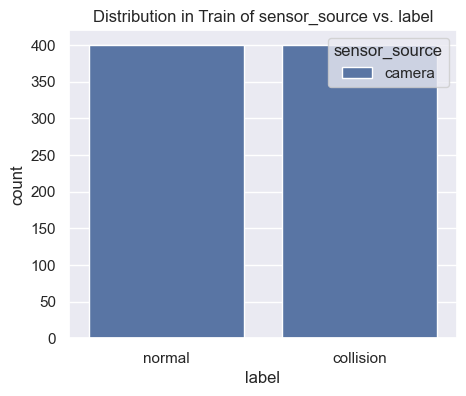

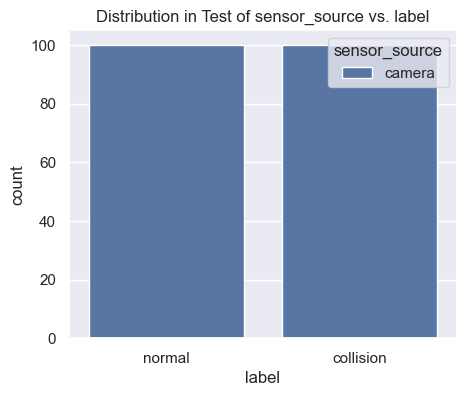

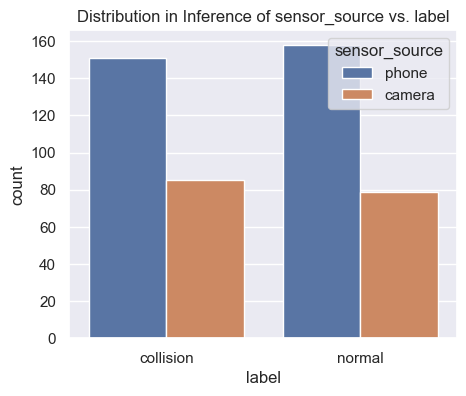

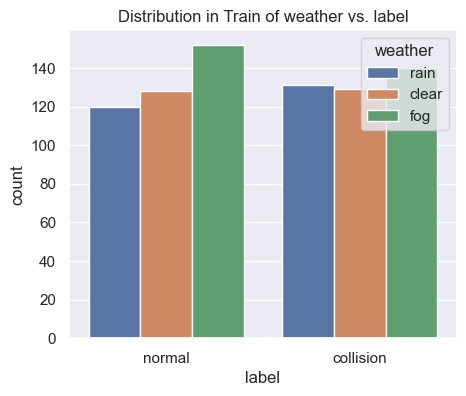

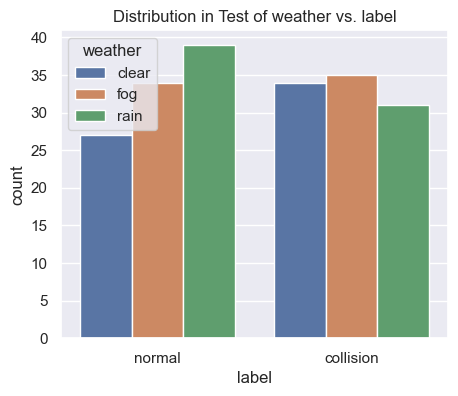

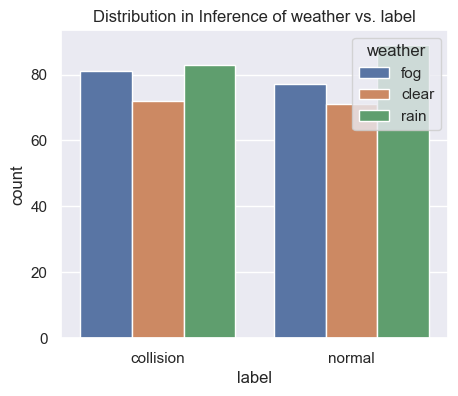

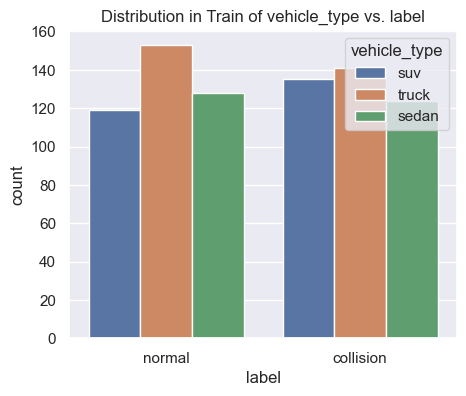

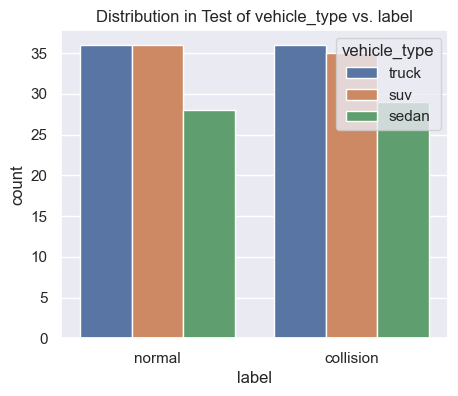

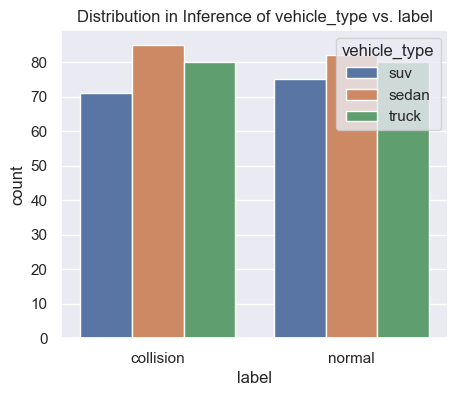

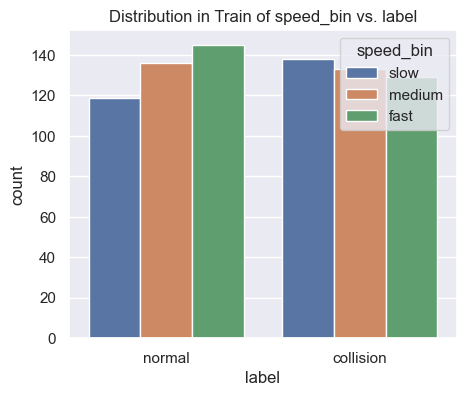

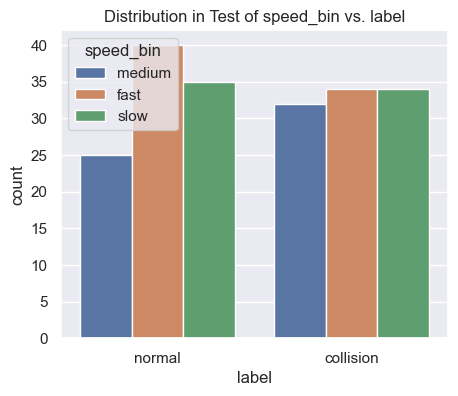

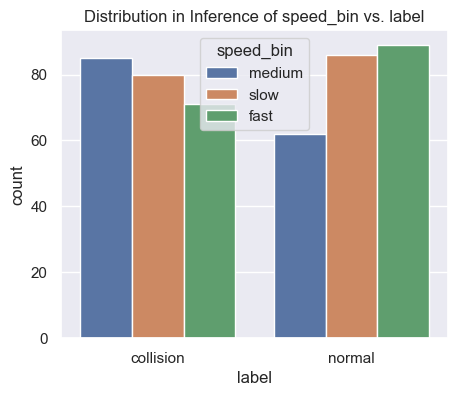

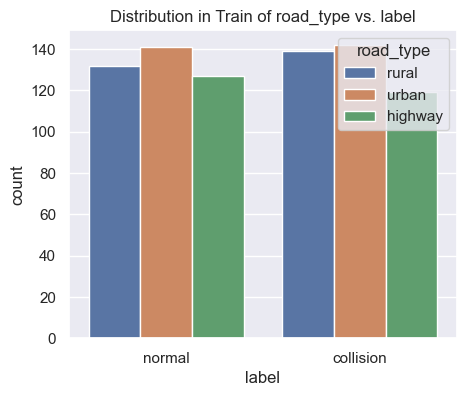

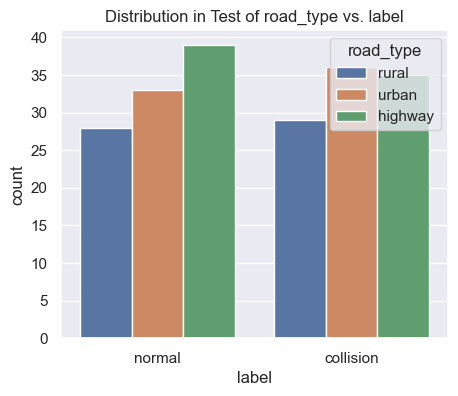

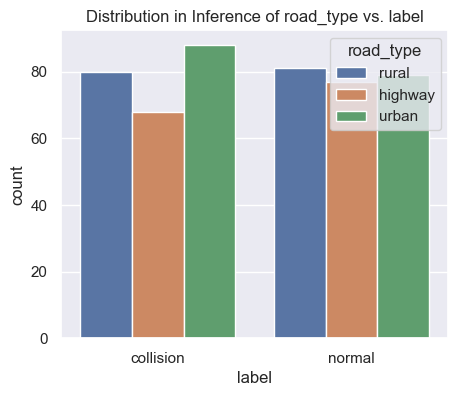

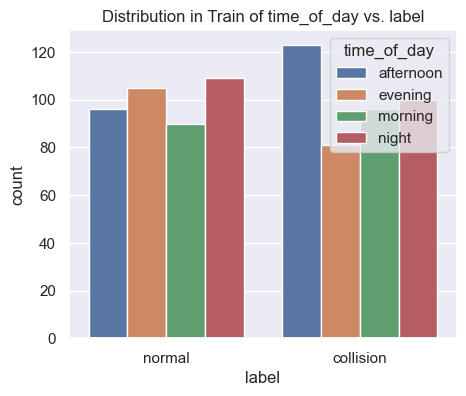

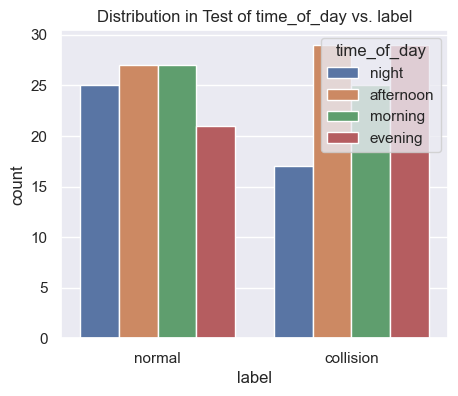

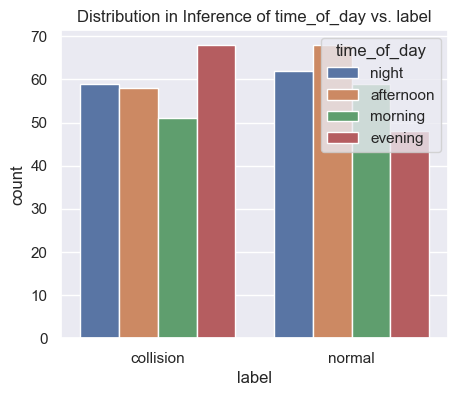

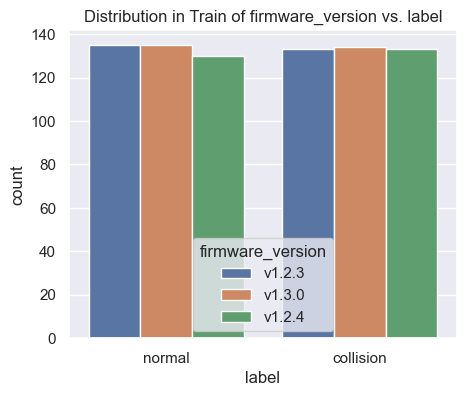

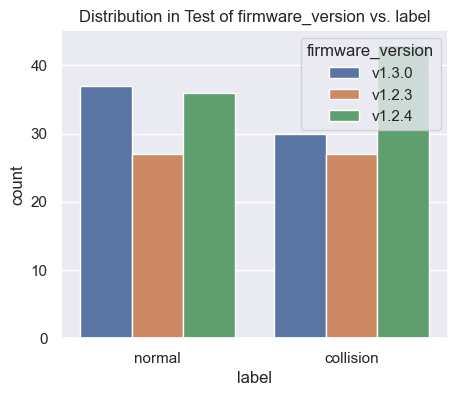

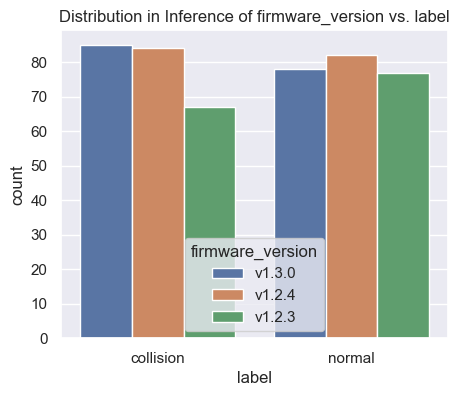

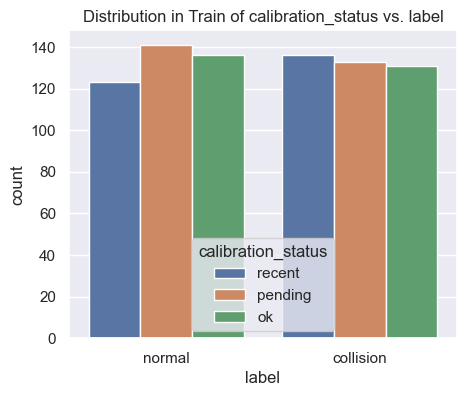

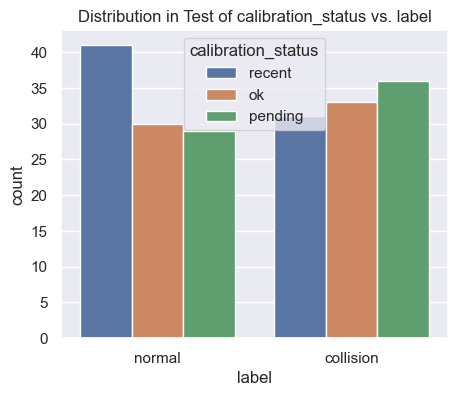

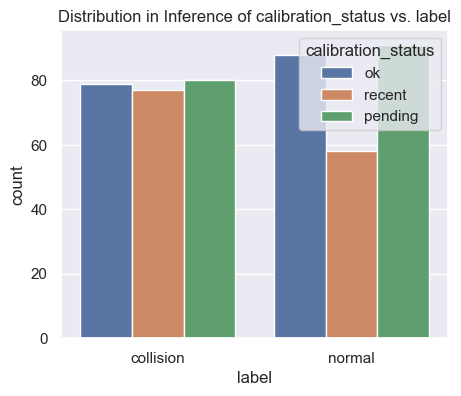

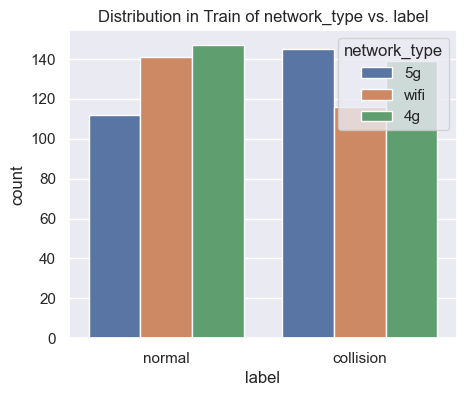

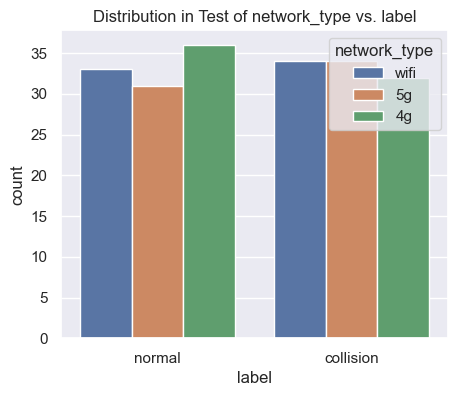

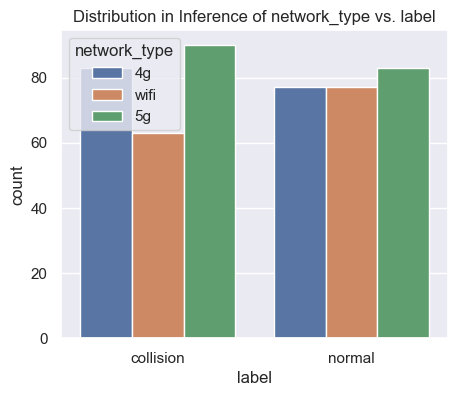

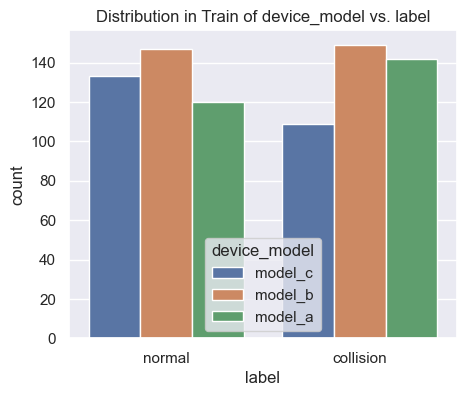

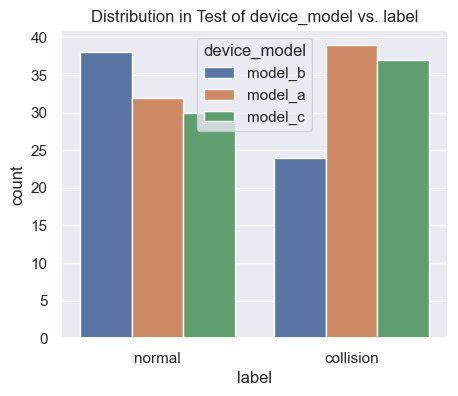

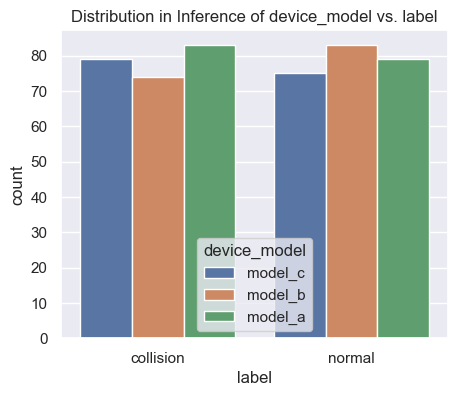

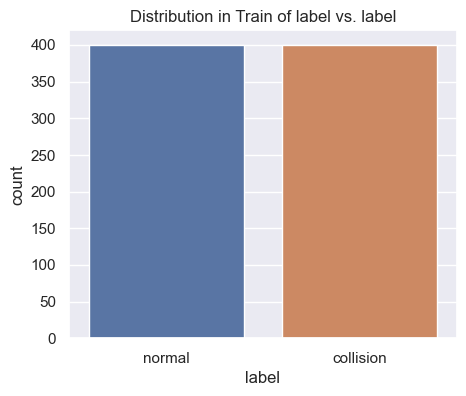

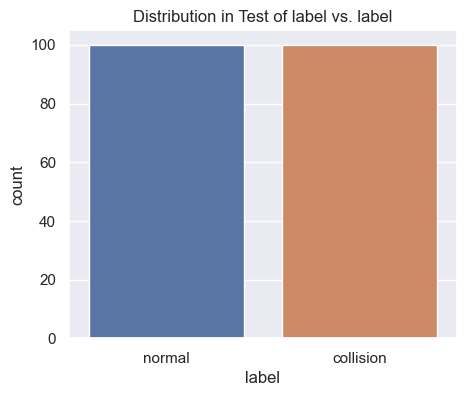

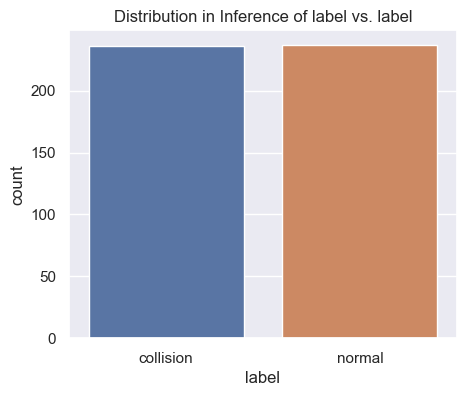

In [36]:
sns.set_theme(style="darkgrid")

df_names = ['Train', 'Test', 'Inference']
df_sets = [df_train_cat, df_test_cat, df_inf_cat]

target = 'label'

for cat_var in df_train_cat.columns: # All sets have the same ordered columns
    for i, df_set in enumerate(df_sets):
        plt.figure(figsize=(5, 4))
        ax = sns.countplot(x = target,  hue = cat_var, data=df_set)
        plt.title(f'Distribution in {df_names[i]} of {cat_var} vs. {target}')
        plt.show()

#### Main conclusions EDA - Categorical features:
1. Sensor source: Train and Test sets have data only from cameras, while Inference has it mostly from phones. This could be a strong reason from the drift we observed between sets.
2. Distribution of other features vary between the three sets but not greatly.
3. Recent calibration in the Inference seems to be lest frequent than in Train and Test, which could also influence the different results observed.
4. All sets have a balanced target variable between "normal" and "collision", which discards a class imbalance as an issue.

In [37]:
df_inf['sensor_source'].value_counts()

sensor_source
phone     309
camera    164
Name: count, dtype: int64

In [38]:
print(f"Percentage of source camera in Inference set: {round(df_inf['sensor_source'].value_counts().min()/df_inf['sensor_source'].value_counts().sum()*100, 2)}%")

Percentage of source camera in Inference set: 34.67%


We can see that practically 1 out of 3 samples from Inference are from cameras, while 2 out of 3 are from phones.

### Analyzing integer type columns:

In [39]:
df_train_int = df_train.select_dtypes(include=['int64', 'float']).copy()
df_test_int = df_test.select_dtypes(include=['int64', 'float']).copy()
df_inf_int = df_inf.select_dtypes(include=['int64', 'float']).copy()
df_test_int.sample(5)

,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,z_fft_max,z_fft_mean,xy_corr,xz_corr,yz_corr,temperature,humidity,altitude,battery_level,gps_accuracy
67,0.063348,0.146567,0.268240,-0.211643,0.479883,-0.446370,-1.348534,17,2.549469,0.018702,...,982.775144,20.362915,0.170487,-0.125581,-0.018688,18,35,309,57,4.563173
162,0.059285,0.142965,0.269068,-0.217576,0.486643,-0.386596,-1.321607,20,2.395367,0.015365,...,984.166499,19.983487,0.195354,0.177784,-0.473466,28,57,978,95,3.676792
38,0.063125,0.146337,0.282011,-0.224561,0.506572,-0.377881,-1.310068,14,2.539924,0.021343,...,984.033841,19.980753,0.199552,0.217128,-0.547115,33,61,910,57,7.152448
26,0.107669,0.286449,1.950869,-0.219792,2.170661,3.601658,18.469379,1,9.364542,0.010716,...,982.155642,20.653494,-0.067884,-0.772822,0.054553,10,27,428,24,8.761115
17,0.059770,0.139478,0.243706,-0.244882,0.488588,-0.415136,-1.297579,15,2.302652,0.019877,...,984.368776,19.990479,0.175467,0.172486,-0.568639,16,27,501,67,7.712726


In [40]:
print(f'All integer dataframes have the same columns and in the same order?\n{df_train_int.columns.tolist() == df_test_int.columns.tolist() and df_test_int.columns.tolist() == df_inf_int.columns.tolist()}')

All integer dataframes have the same columns and in the same order?
True


We insert the target variable in the same dataframe as the integers for further analysis:

In [41]:
last_index = len(df_train_int.columns)

df_train_int.insert(last_index, 'label', y_train)
df_test_int.insert(last_index, 'label', y_test)
df_inf_int.insert(last_index, 'label', y_inf)

In [42]:
df_train_int.head(2)

,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,z_fft_mean,xy_corr,xz_corr,yz_corr,temperature,humidity,altitude,battery_level,gps_accuracy,label
0,0.057289,0.140447,0.265758,-0.214983,0.480742,-0.388161,-1.292653,17,2.300756,0.014241,...,20.016058,0.200941,0.246431,-0.494871,20,46,409,93,6.111424,normal
1,0.058397,0.147305,0.315987,-0.237875,0.553862,-0.371543,-1.247677,12,2.510906,0.015394,...,19.961311,0.197655,0.227833,-0.473790,18,34,632,94,5.448867,normal


In [43]:
df_inf_int.head(2)

,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,z_fft_mean,xy_corr,xz_corr,yz_corr,temperature,humidity,altitude,battery_level,gps_accuracy,label
0,2.578586,2.362892,8.999561,-5.200753,14.200314,0.193760,1.400440,31,1223.236383,2.995496,...,27.944296,-0.286199,-0.178732,0.219202,12,49,996,79,5.570705,collision
1,-0.114423,2.185548,10.289834,-5.283784,15.573618,2.164783,7.702143,5,478.971240,0.343485,...,25.651496,0.117055,-0.084238,0.059663,22,75,607,81,3.181146,collision


In [44]:
df_train_int.columns

Index(['x_mean', 'x_std', 'x_max', 'x_min', 'x_range', 'x_skew', 'x_kurtosis',
       'x_n_peaks', 'x_energy', 'y_mean', 'y_std', 'y_max', 'y_min', 'y_range',
       'y_skew', 'y_kurtosis', 'y_n_peaks', 'y_energy', 'z_mean', 'z_std',
       'z_max', 'z_min', 'z_range', 'z_skew', 'z_kurtosis', 'z_n_peaks',
       'z_energy', 'mag_mean', 'mag_std', 'mag_max', 'max_delta_mag',
       'sudden_change_score', 'x_fft_max', 'x_fft_mean', 'y_fft_max',
       'y_fft_mean', 'z_fft_max', 'z_fft_mean', 'xy_corr', 'xz_corr',
       'yz_corr', 'temperature', 'humidity', 'altitude', 'battery_level',
       'gps_accuracy', 'label'],
      dtype='object')

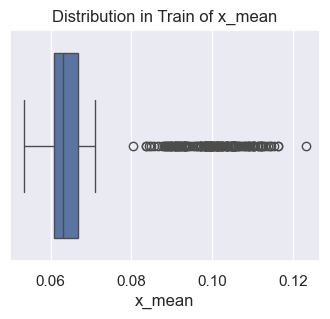

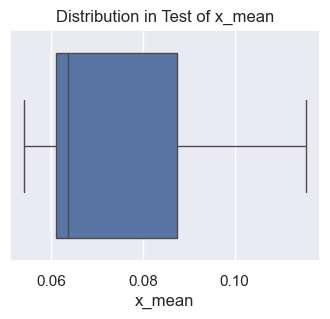

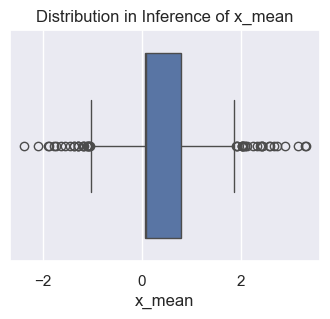

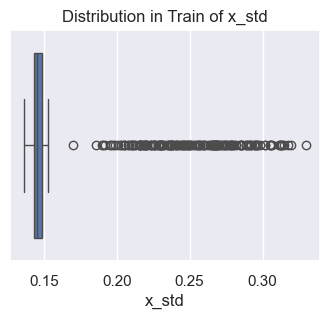

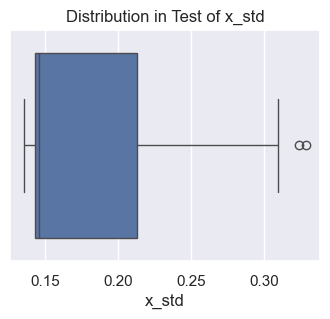

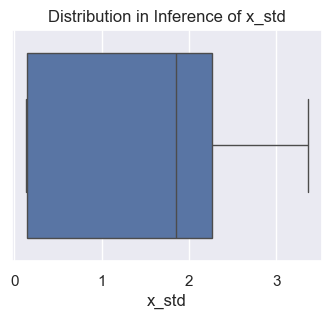

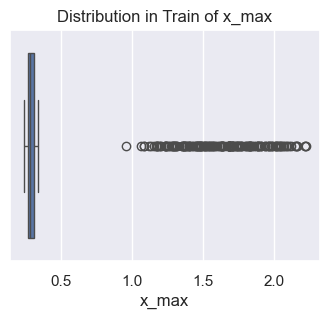

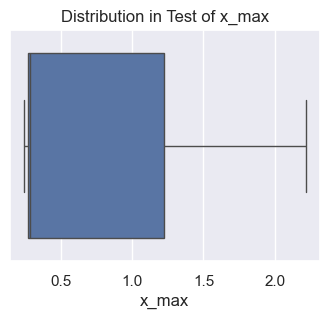

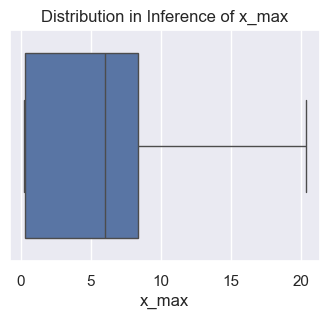

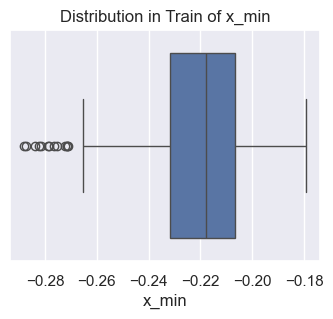

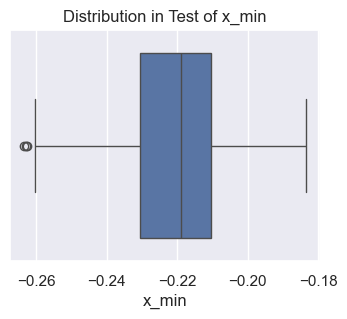

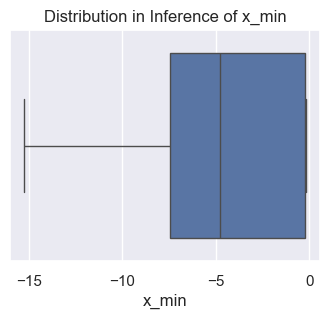

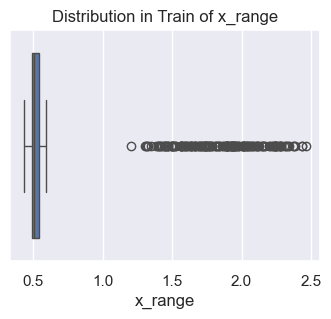

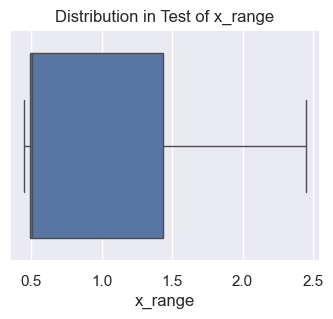

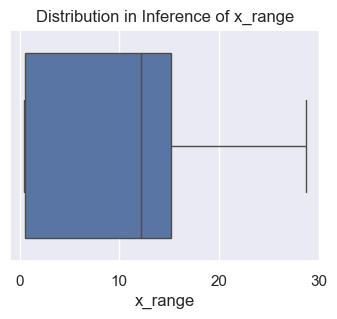

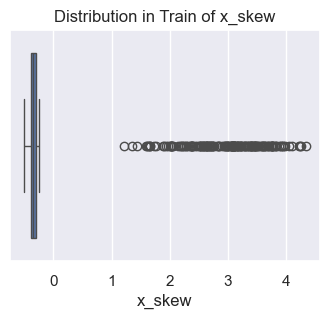

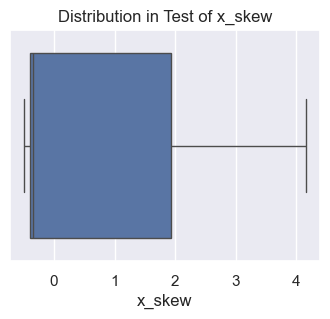

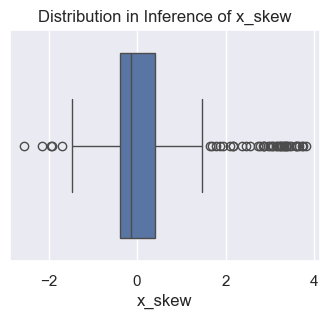

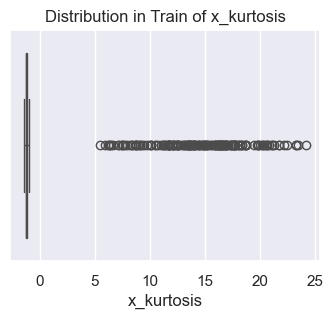

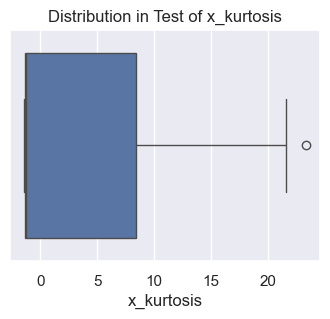

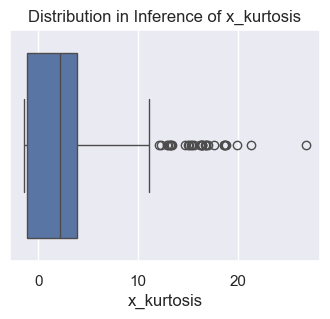

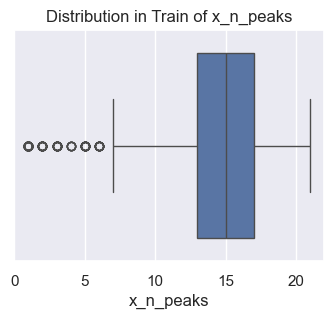

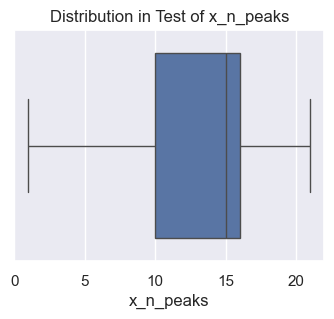

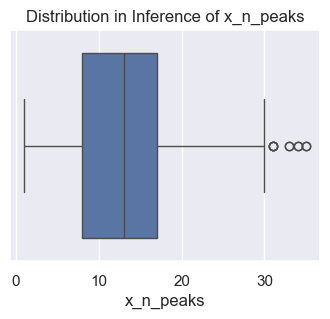

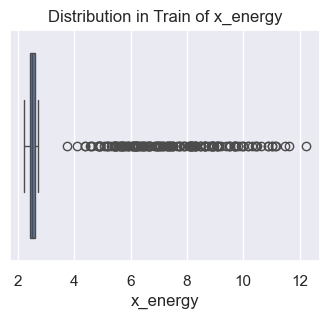

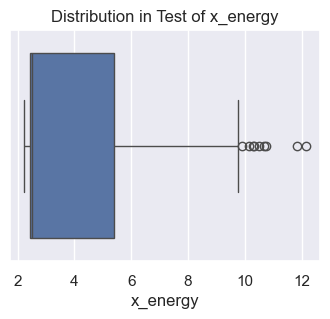

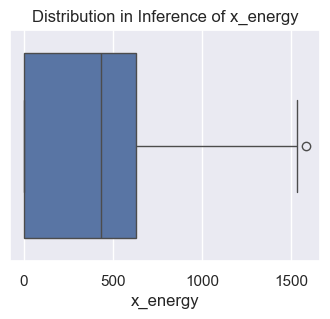

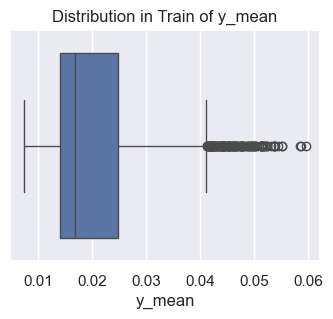

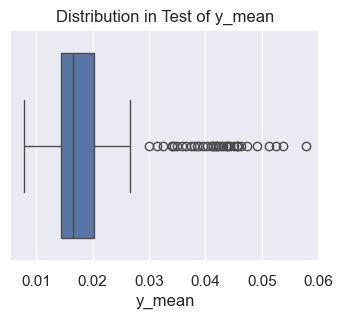

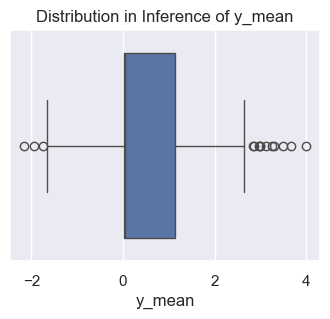

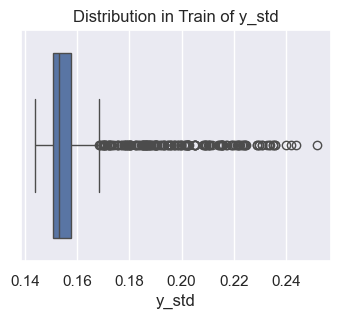

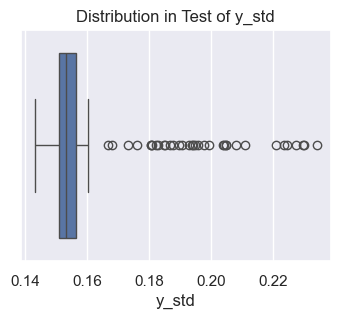

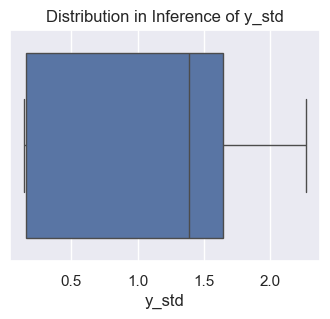

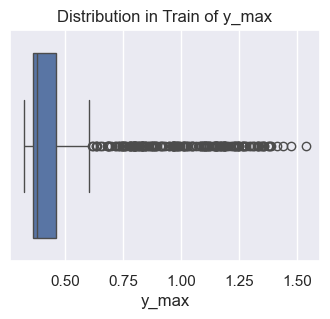

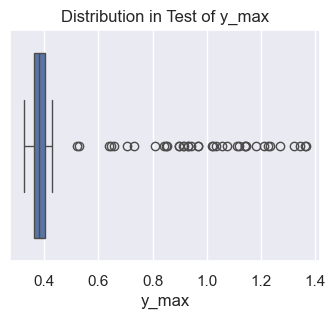

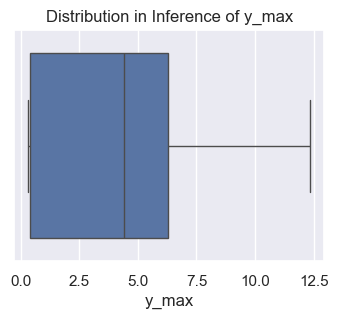

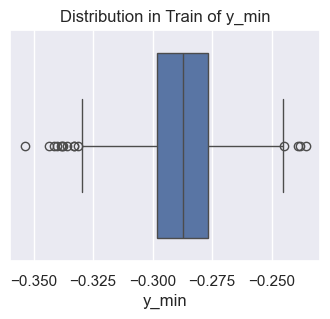

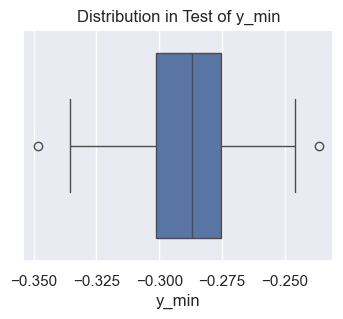

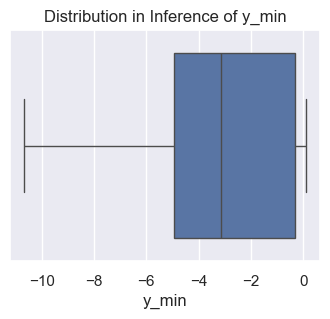

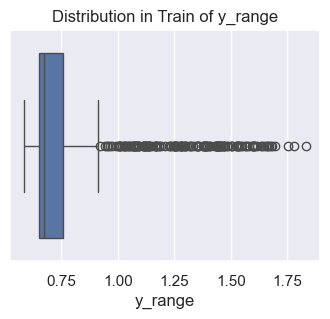

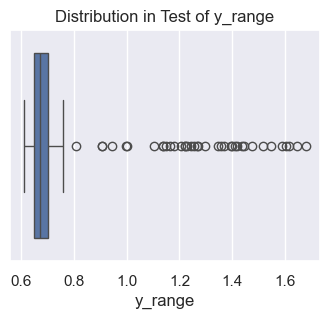

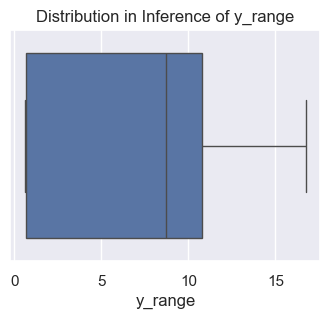

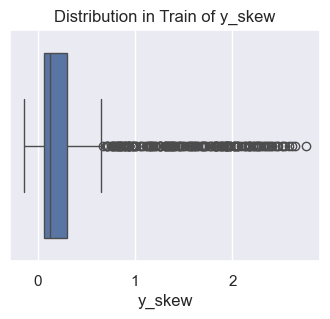

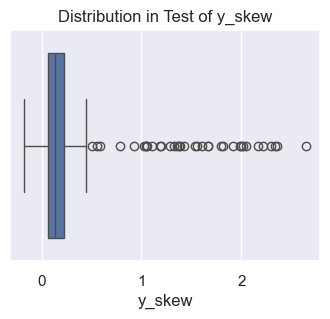

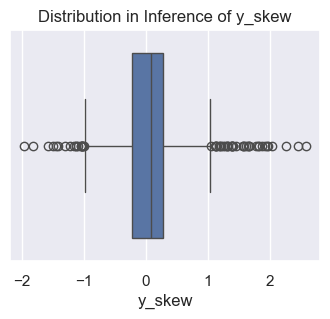

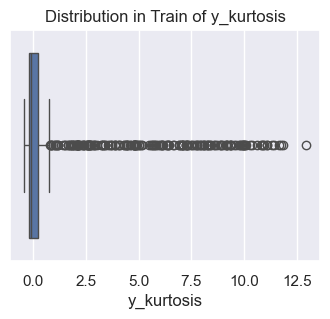

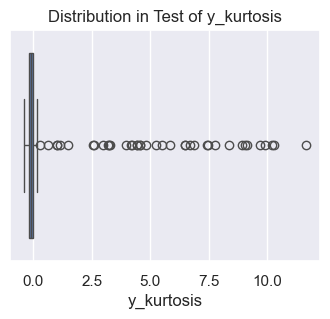

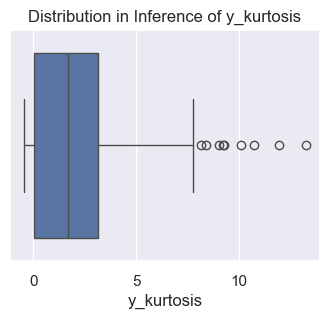

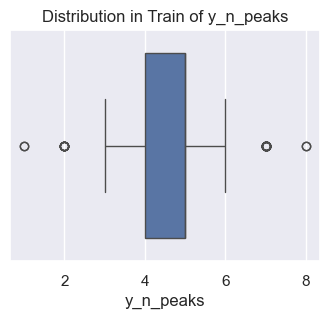

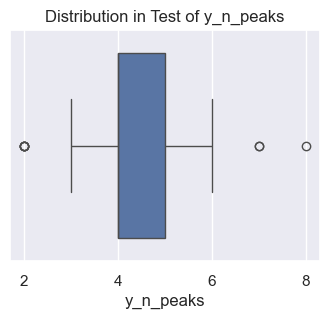

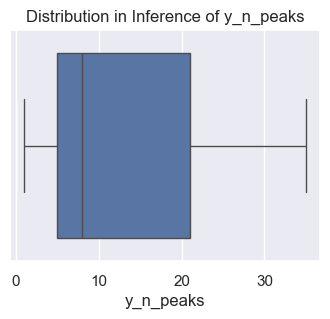

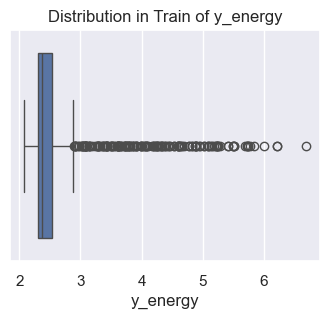

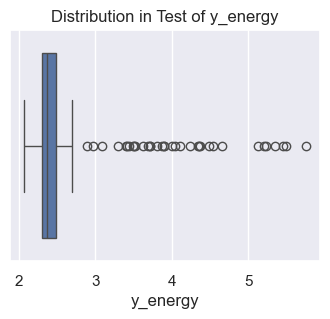

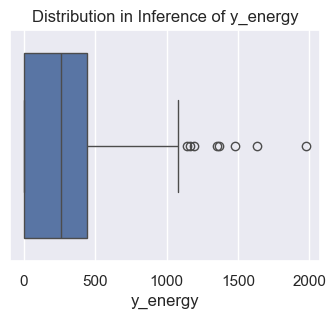

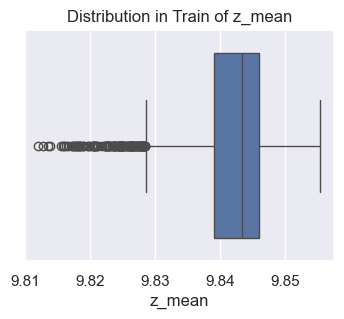

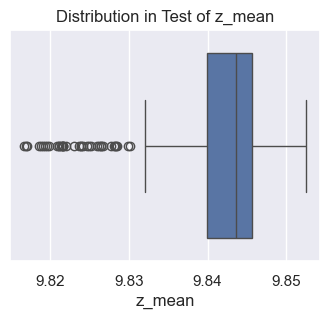

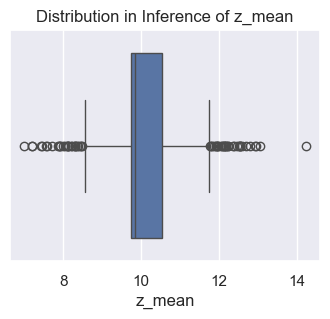

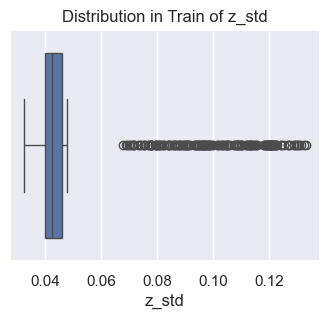

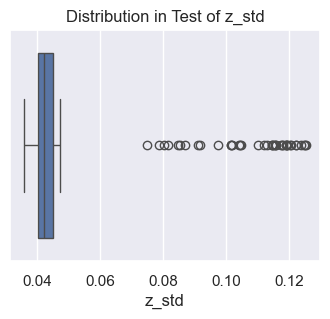

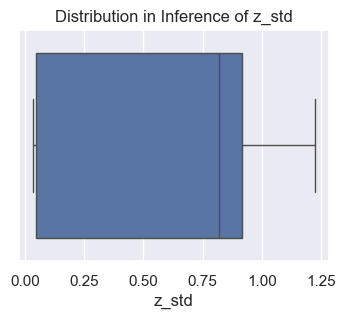

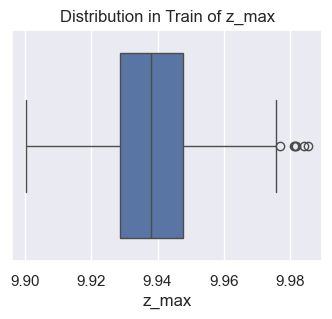

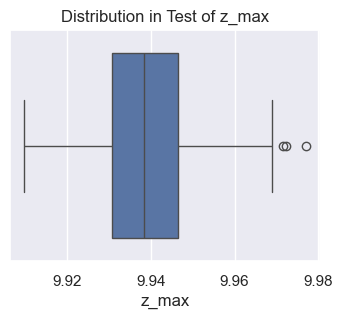

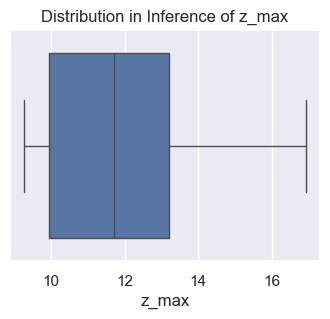

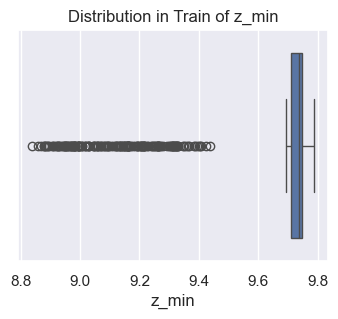

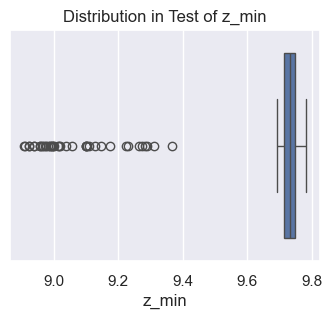

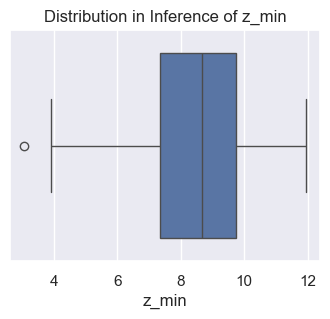

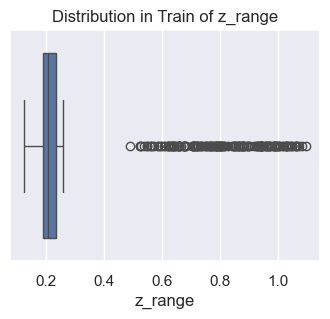

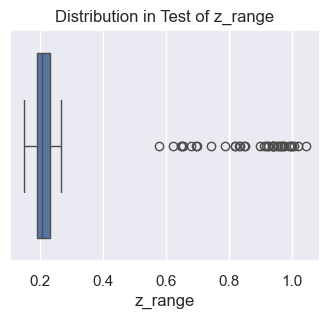

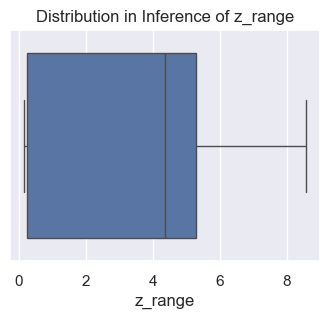

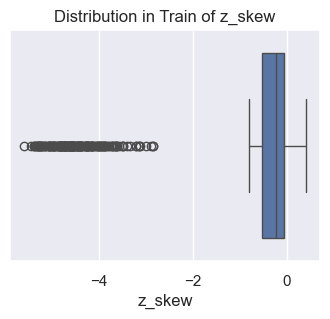

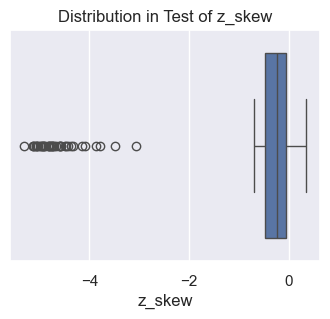

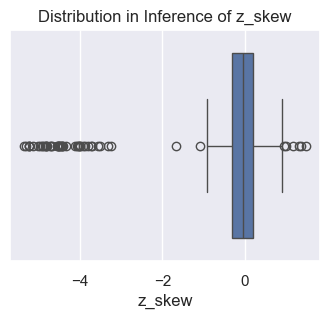

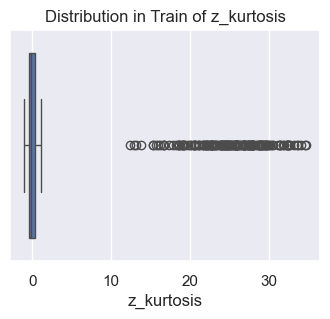

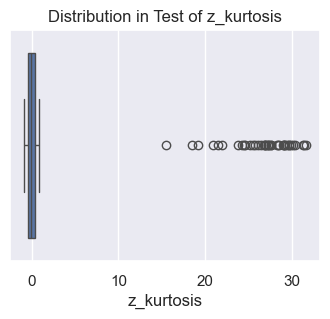

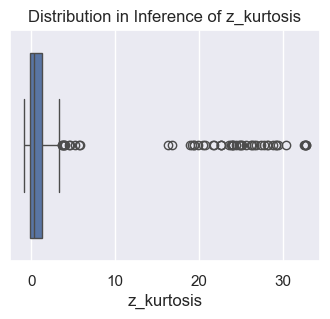

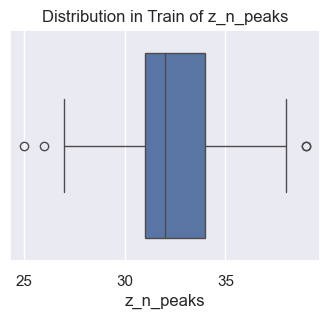

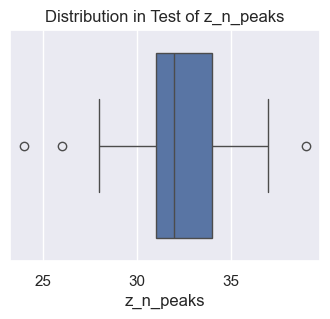

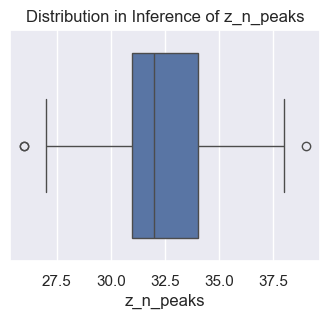

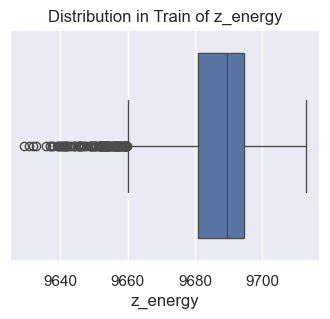

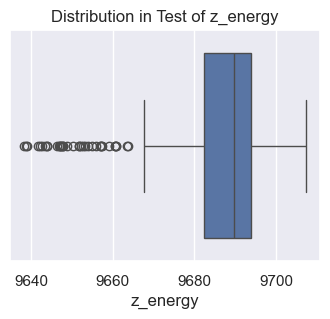

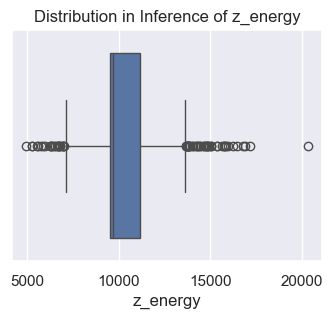

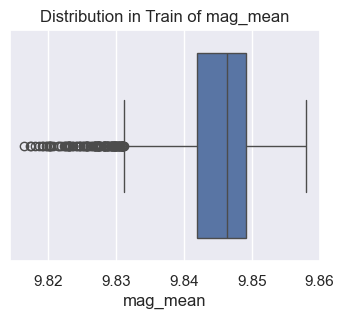

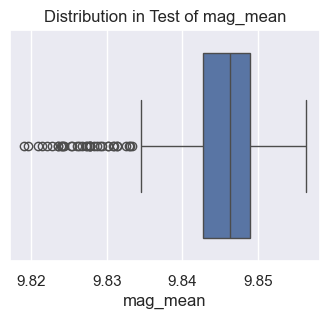

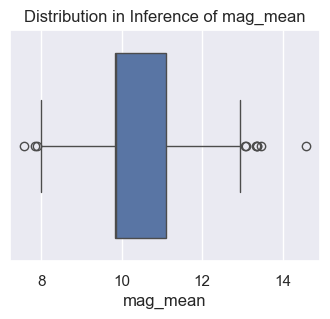

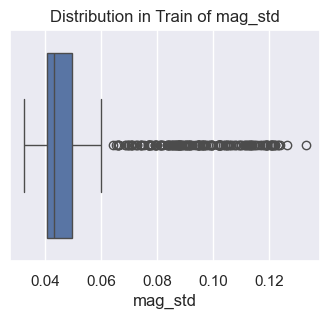

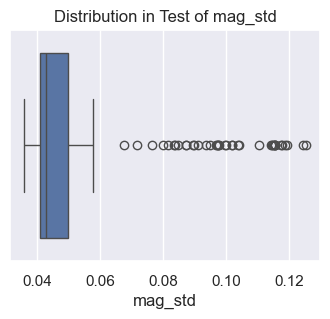

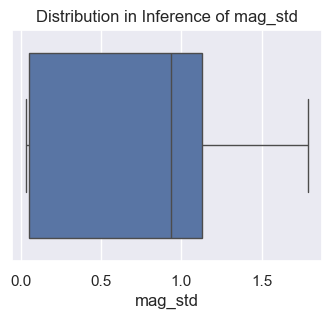

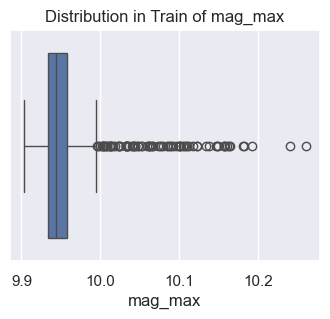

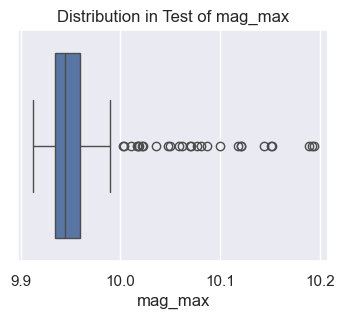

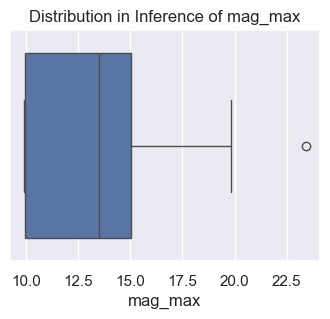

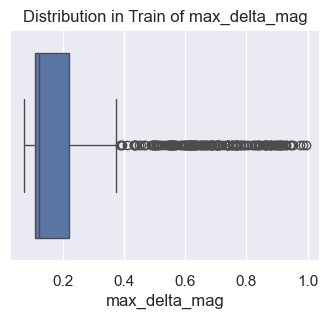

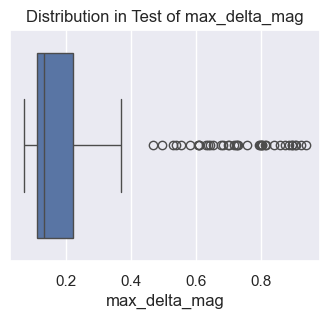

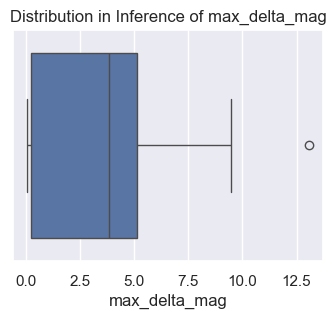

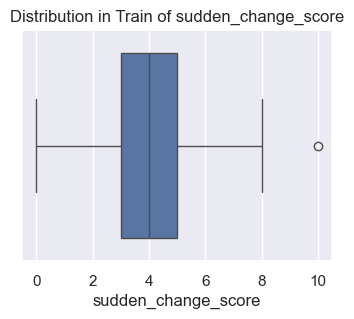

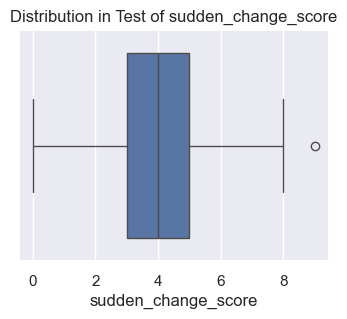

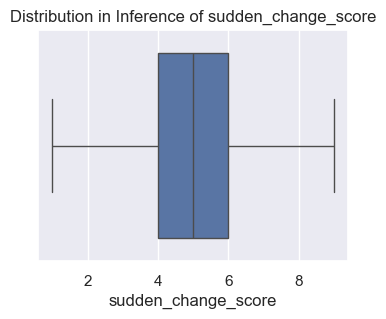

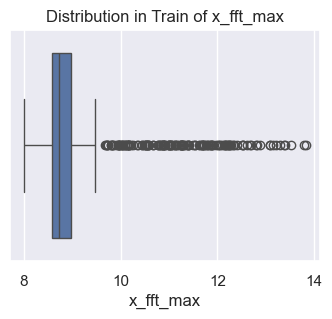

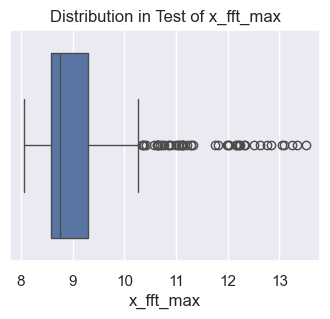

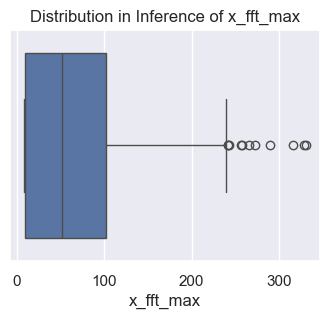

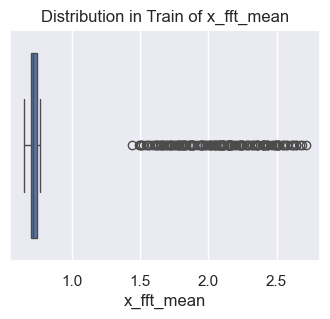

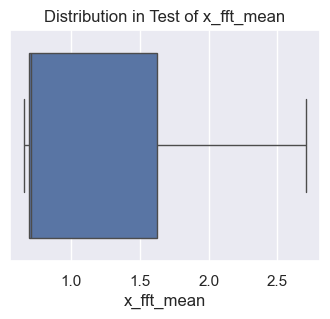

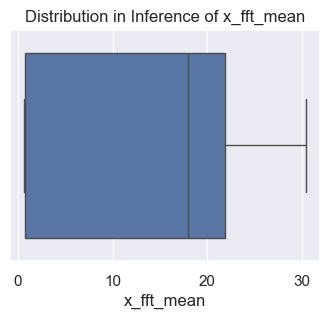

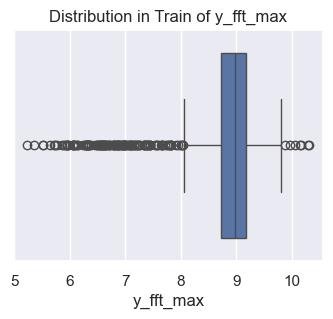

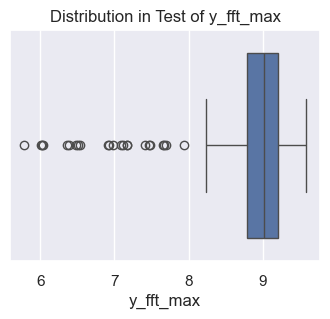

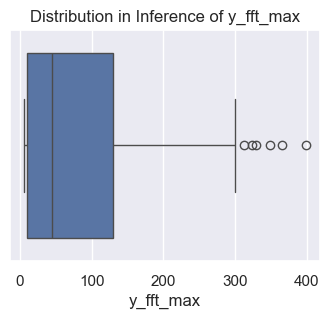

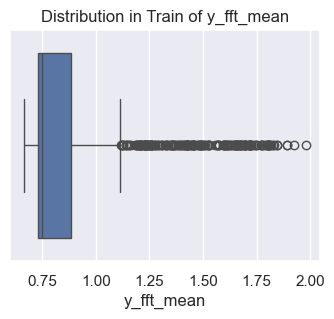

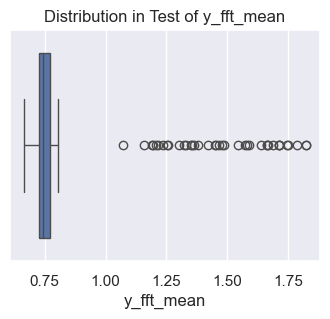

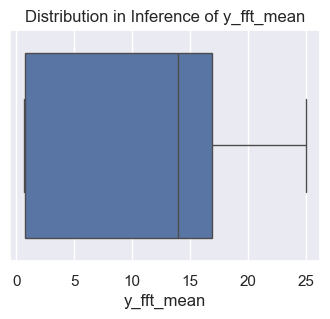

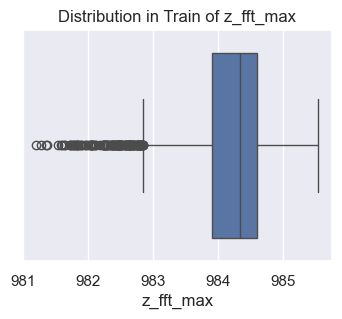

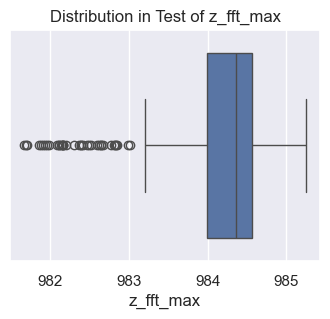

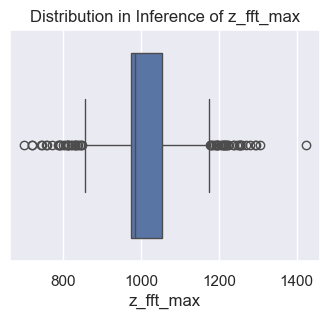

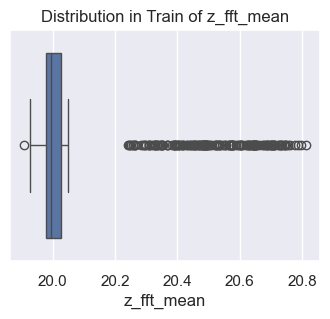

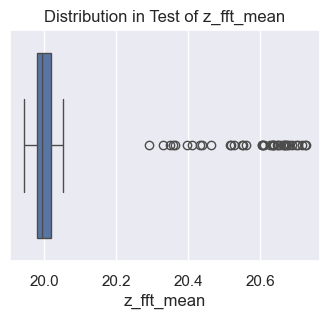

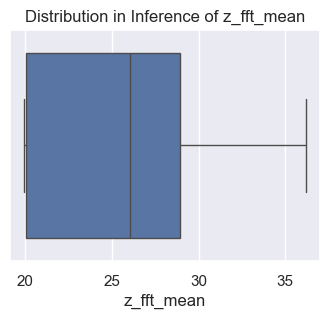

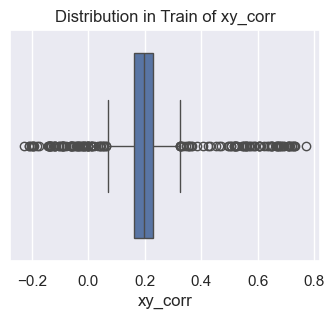

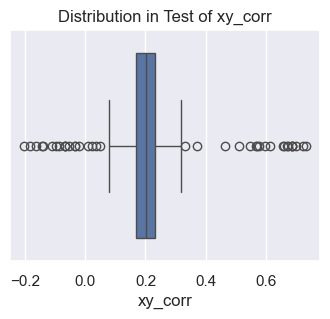

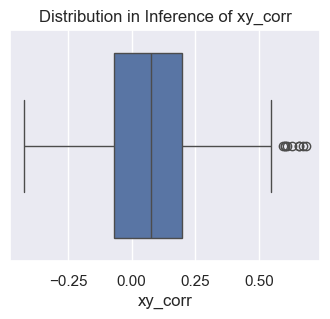

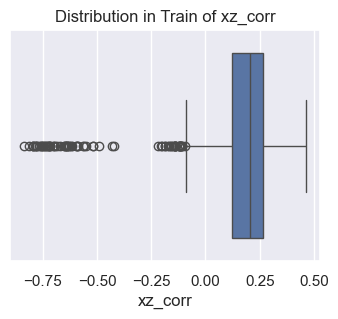

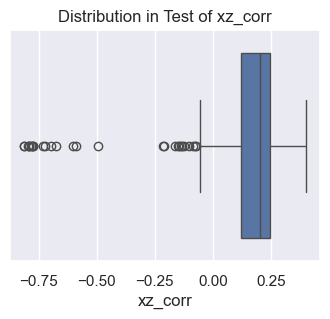

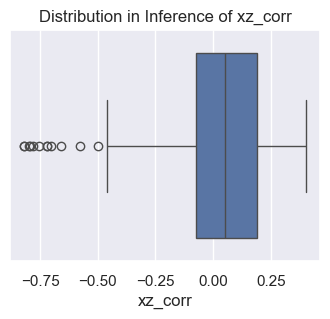

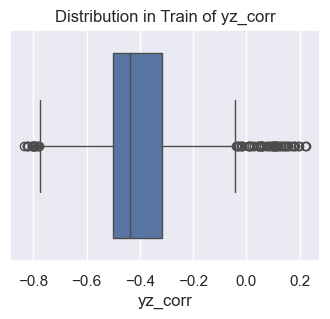

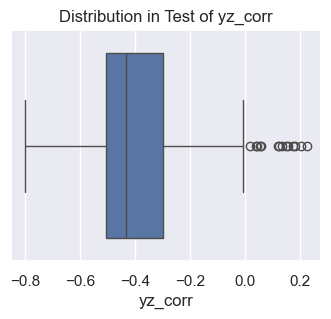

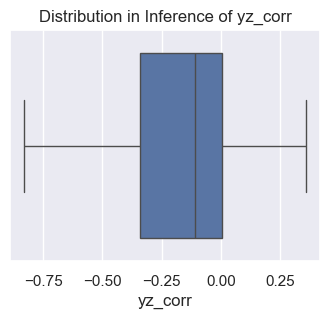

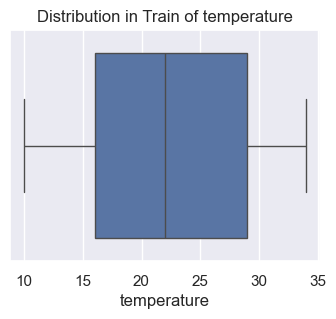

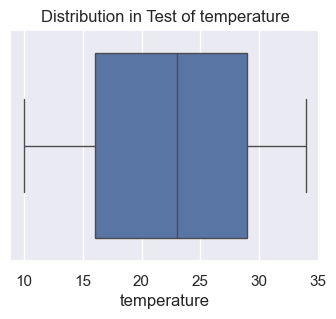

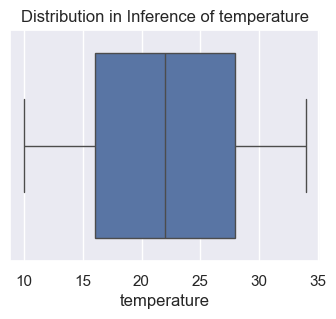

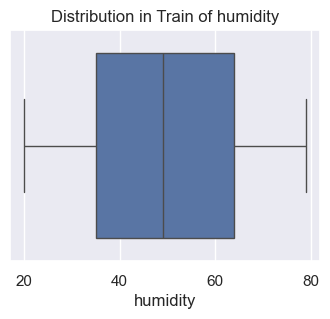

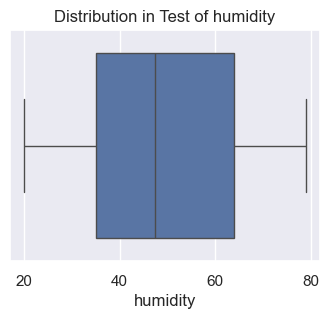

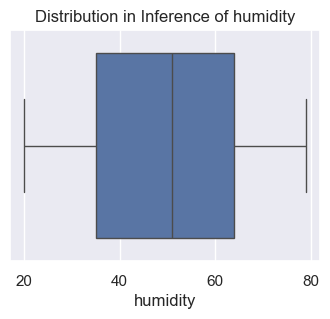

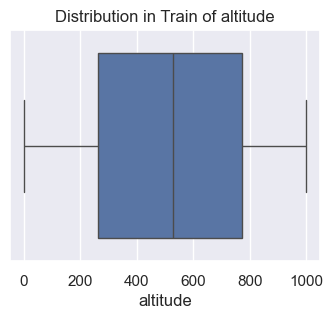

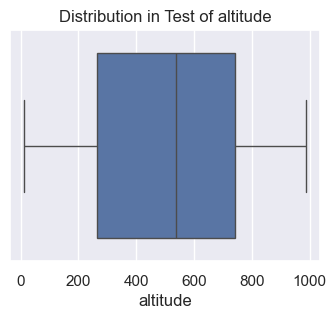

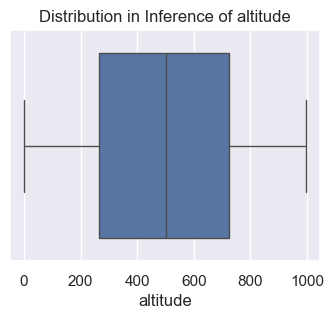

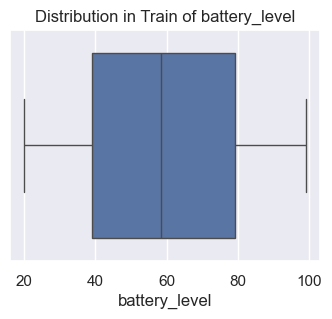

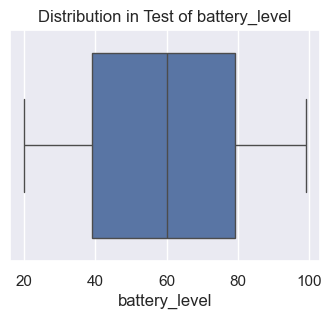

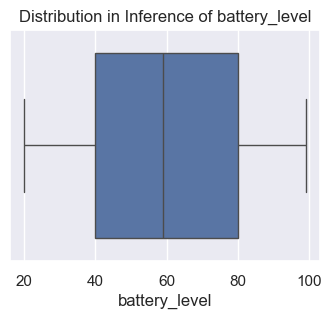

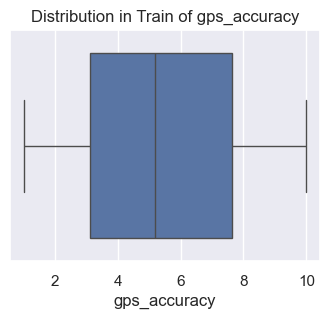

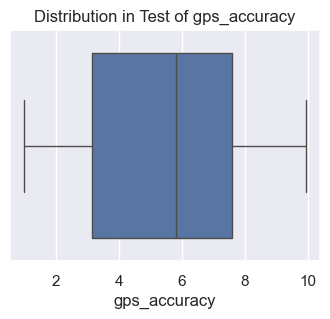

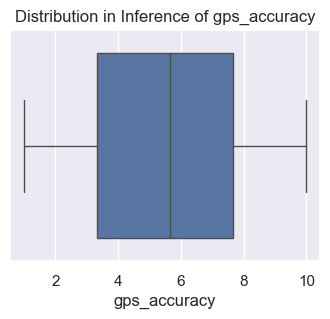

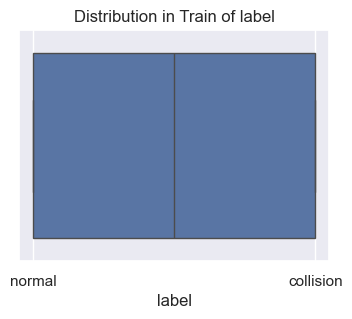

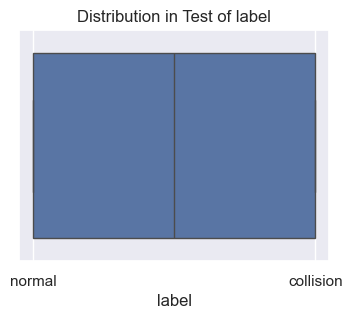

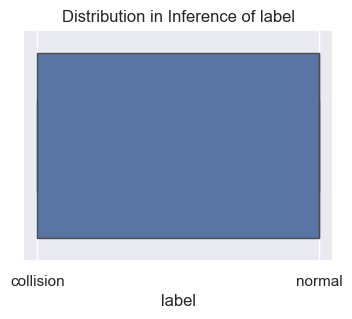

In [45]:
df_sets = [df_train_int, df_test_int, df_inf_int]

for int_var in df_train_int.columns:
    for i, df_set in enumerate(df_sets):

        plt.figure(figsize=(4, 3))
        ax = sns.boxplot(x=int_var, data=df_set)
        
        plt.title(f'Distribution in {df_names[i]} of {int_var}')
        plt.show()

#### Main conclusions EDA - Numerical features:
1. Distribution of x_n_peaks and y_n_peaks is clearly different between Train and Test compared to Inference.
2. sudden_change_score tends to be higher in Inference, being left skewed while is right skewed in Train and Test.
3. Many other numerical features have a very big drift in Inference, such as x_std, x_max, x_range, x_skew, y_max, z_energy, mag_mean, y_fft_max, etc.
4. We can observe that a scaling of the numeric features wasn't implemented, which may have also hurted the model's performance.

So far, we have strong evidence that the main cause of the drift is the sensor source, more than any other feature.

### Performance of the model when the sensor source is only camera:

We'll analyze now the performance of the model on the Inference set when the source is only camera, to check if under this scenario its metrics resemble what we've seen on the Test set.

In [46]:
df_inf['y_pred'] = y_inf_pred

df_inf_camera = df_inf[df_inf['sensor_source'] == 'camera']

In [47]:
df_inf['sensor_source'].value_counts()

sensor_source
phone     309
camera    164
Name: count, dtype: int64

In [48]:
y_inf_camera = df_inf_camera['label']
y_pred_camera = df_inf_camera['y_pred']

print(f'Train:\n{classification_report(y_train, y_train_pred)}\n\n')
print(f'Test:\n{classification_report(y_test, y_test_pred)}\n\n')
print(f'Inference (only camera):\n{classification_report(y_inf_camera, y_pred_camera)}\n\n')

Train:
              precision    recall  f1-score   support

   collision       1.00      1.00      1.00       400
      normal       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



Test:
              precision    recall  f1-score   support

   collision       1.00      0.89      0.94       100
      normal       0.90      1.00      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



Inference (only camera):
              precision    recall  f1-score   support

   collision       1.00      0.88      0.94        85
      normal       0.89      1.00      0.94        79

    accuracy                           0.94       164
   macro avg       0.94      0.94      0.94       164
weighted avg       0.95      0.9

We can assert  that when the sensor source is a camera (only), the performance on the Inference is very similar to the performance on the Test. This is the main factor for the drift we observed.

### Performance of the model when the sensor source is only phone:

In [49]:
df_inf_phone = df_inf[df_inf['sensor_source'] == 'phone']

y_inf_phone = df_inf_phone['label']
y_pred_phone = df_inf_phone['y_pred']

print(f'Train:\n{classification_report(y_train, y_train_pred)}\n\n')
print(f'Test:\n{classification_report(y_test, y_test_pred)}\n\n')
print(f'Inference (only phone):\n{classification_report(y_inf_phone, y_pred_phone)}\n\n')

Train:
              precision    recall  f1-score   support

   collision       1.00      1.00      1.00       400
      normal       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



Test:
              precision    recall  f1-score   support

   collision       1.00      0.89      0.94       100
      normal       0.90      1.00      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



Inference (only phone):
              precision    recall  f1-score   support

   collision       0.49      1.00      0.66       151
      normal       0.00      0.00      0.00       158

    accuracy                           0.49       309
   macro avg       0.24      0.50      0.33       309
weighted avg       0.24      0.49

The accuracy of the model on samples from the Inference with the sensor source being phone is below 50%, which makes sense since the model was trained and tested only with samples from cameras and on the inference, as seen before, around 66% of them come from phones, which represents a big data shift.

### Analyzing float features and their correlation with the sensor source:

In [50]:
df_train_float = df_train.select_dtypes(include=['float']).copy()
df_test_float = df_test.select_dtypes(include=['float']).copy()
df_inf_float = df_inf.select_dtypes(include=['float']).copy()
df_test_float.sample(3)

,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_energy,y_mean,y_std,...,x_fft_max,x_fft_mean,y_fft_max,y_fft_mean,z_fft_max,z_fft_mean,xy_corr,xz_corr,yz_corr,gps_accuracy
56,0.056544,0.142281,0.256132,-0.193344,0.449476,-0.350959,-1.426503,2.344109,0.014761,0.146837,...,8.751276,0.664366,8.657263,0.741931,984.790173,19.976647,0.227106,0.301004,-0.490449,6.117775
75,0.064121,0.145420,0.274855,-0.218563,0.493418,-0.352668,-1.238360,2.525847,0.017821,0.149217,...,8.654658,0.701107,8.872301,0.721081,984.503236,20.004696,0.172266,0.099606,-0.471662,2.103761
15,0.062127,0.143211,0.272471,-0.237891,0.510362,-0.444553,-1.140285,2.436928,0.018280,0.151902,...,8.371763,0.758050,9.282773,0.699726,984.355501,19.981132,0.254960,0.258117,-0.434930,4.817392


In [51]:
print(f'All float dataframes have the same columns and in the same order?\n{df_train_float.columns.tolist() == df_test_float.columns.tolist() and df_test_float.columns.tolist() == df_inf_float.columns.tolist()}')

All float dataframes have the same columns and in the same order?
True


We insert the sensor_source variable in the same dataframe as the integers for further analysis:

In [52]:
last_index = len(df_train_float.columns)

df_train_float.insert(last_index, 'sensor_source', df_train['sensor_source'])
df_test_float.insert(last_index, 'sensor_source', df_test['sensor_source'])
df_inf_float.insert(last_index, 'sensor_source', df_inf['sensor_source'])

In [53]:
df_inf_float.sample(3)

,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_energy,y_mean,y_std,...,x_fft_mean,y_fft_max,y_fft_mean,z_fft_max,z_fft_mean,xy_corr,xz_corr,yz_corr,gps_accuracy,sensor_source
119,-1.187228,2.080399,6.105683,-7.842500,13.948184,0.011165,3.598622,573.757124,-0.937271,1.577193,...,20.840792,93.727125,15.768578,1010.249157,28.846717,-0.012887,-0.181658,0.192558,6.891781,phone
158,0.226324,1.896509,9.096482,-5.305313,14.401794,0.958465,4.225370,364.796894,1.911772,1.477437,...,16.870828,191.177187,16.549562,1015.547860,29.058754,0.033136,0.153656,0.201460,7.965025,phone
87,-0.672998,2.825276,9.651035,-11.072069,20.723104,-0.058334,3.110906,843.510984,1.020458,1.865147,...,25.553536,102.045750,18.913124,898.198272,25.640718,0.184968,0.095505,0.049916,2.335964,phone


We label encode the sensor_source feature to check the correlation with the others (1 for camera and 0 for phone):

In [54]:
mapping = {'camera': 1, 'phone': 0}

df_inf_float['sensor_source'] = df_inf_float['sensor_source'].map(mapping)

In [55]:
df_inf_float.columns.shape[0]

39

Since there are many columns, we'll analyze their correlation between each other but mainly with "sensor source" with four different graphs.

In [56]:
first_columns = pd.concat([df_inf_float.iloc[:, 0:10], df_inf_float.loc[:, 'sensor_source']], axis=1)
second_columns = pd.concat([df_inf_float.iloc[:, 10:20], df_inf_float.loc[:, 'sensor_source']], axis=1)
third_columns = pd.concat([df_inf_float.iloc[:, 20:29], df_inf_float.loc[:, 'sensor_source']], axis=1)
fourth_columns = pd.concat([df_inf_float.iloc[:, 29:38], df_inf_float.loc[:, 'sensor_source']], axis=1)

In [57]:
fourth_columns.head(3)

,x_fft_mean,y_fft_max,y_fft_mean,z_fft_max,z_fft_mean,xy_corr,xz_corr,yz_corr,gps_accuracy,sensor_source
0,26.229122,299.549597,20.983052,966.220588,27.944296,-0.286199,-0.178732,0.219202,5.570705,0
1,19.289734,34.348545,11.629765,948.139768,25.651496,0.117055,-0.084238,0.059663,3.181146,0
2,0.713313,8.816552,0.708046,984.375989,20.000212,0.191632,0.175655,-0.484616,2.987759,1


Set of features 1:


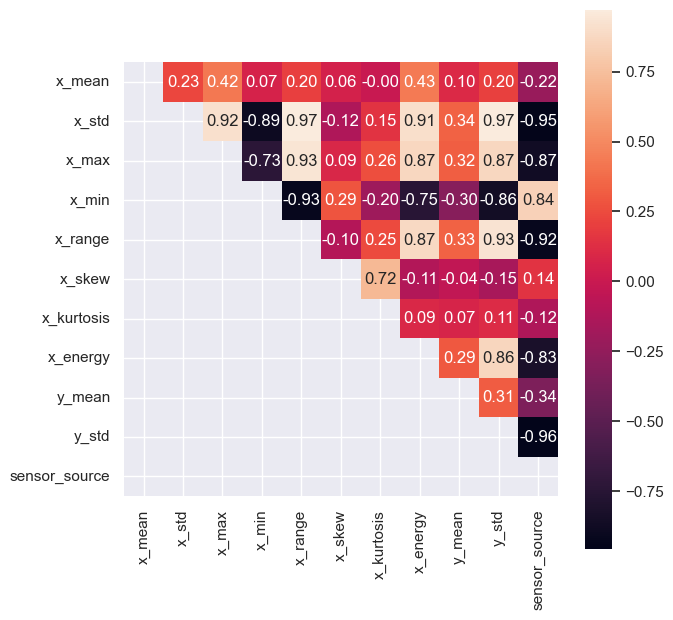

Set of features 2:


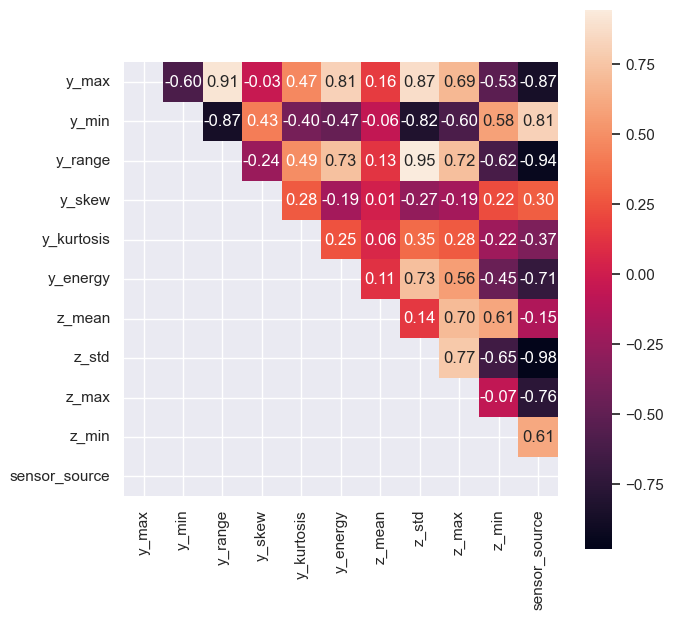

Set of features 3:


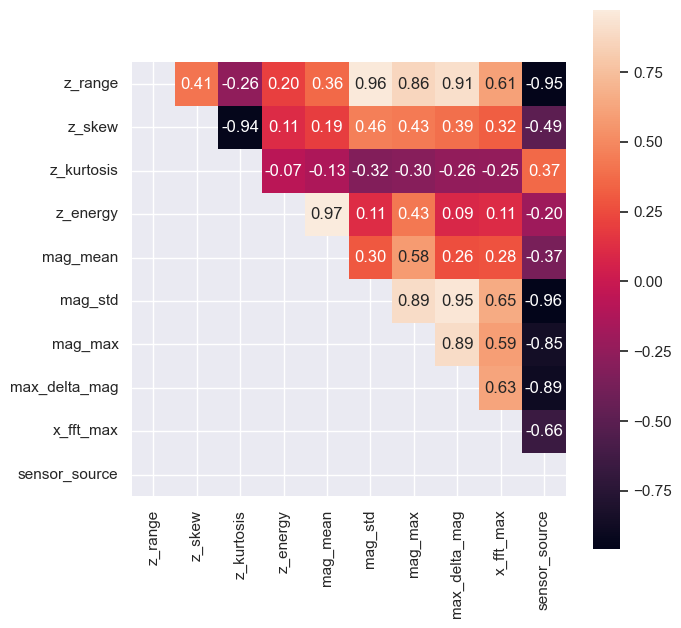

Set of features 4:


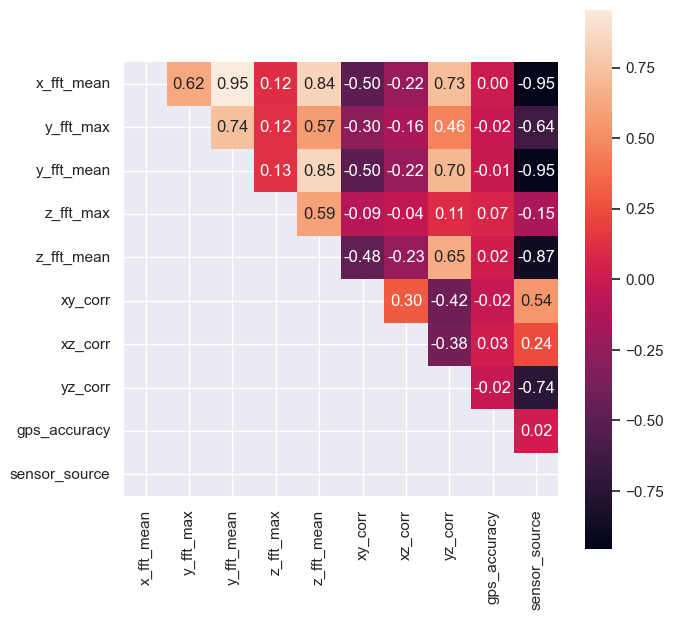

In [58]:
for i, df_col in enumerate([first_columns, second_columns, third_columns, fourth_columns]):
    corr = df_col.corr()

    print(f'Set of features {i+1}:')
    mask = np.tril(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(7, 7))
    ax = sns.heatmap(corr, 
                     annot=True, 
                     fmt=".2f", 
                     mask = mask, square = True)
    plt.show()

We see that there's a high correlation between features, mainly with the sensor source. Features like x_std, x_range, y_std, y_range, z_std, z_range, mag_std, x_fft_mean, y_fft_mean, etc with a correlation greater than 90% should be dropped to avoid redundancy.

Apart from the comparison with the sensor source, other features such as x_fft_mean with y_fft_mean, z_energy with mag_mean, mag_std with max_delta_mag, z_range with mag_std, y_max with y_range, etc could also be dropped (one of them) since their correlation is very high.

In [59]:
y_test.value_counts()

label
normal       100
collision    100
Name: count, dtype: int64

In [60]:
y_train.value_counts()

label
normal       400
collision    400
Name: count, dtype: int64

The three sets are balanced between the two classes.

In [61]:
y_inf.value_counts()

label
normal       237
collision    236
Name: count, dtype: int64

We finish by extracting some information about the preditions in the inference set:

In [62]:
pd.Series(y_inf_pred).value_counts()

collision    384
normal        89
Name: count, dtype: int64

In [63]:
print(f"Percentage of predictions of collision in the Inference set: {round(pd.Series(y_inf_pred).value_counts().max()/pd.Series(y_inf_pred).value_counts().sum()*100, 2)}%")

Percentage of predictions of collision in the Inference set: 81.18%


# ❓ Questions to Reflect On


- What do you observe when comparing the model’s predictions on the new data to its known performance?

- Is there anything in the data that might explain differences in behavior?

- Can you identify patterns or trends related to when the model succeeds or fails?

- Are there signals or features that seem to affect the model’s reliability?

- What could be done in the short term to handle the current situation?

- What are potential long-term steps to improve model performance in similar scenarios?

- What would you want to explore further if given more time or data?

- What assumptions did the model rely on during training — and are they still valid?

### 0. What do you observe when comparing the model’s predictions on the new data to its known performance?

As stated before, the performance of the model on the new data goes sharply down for all its metrics (e.g. accuracy of 94% to 64% and precision from 95% to 74%).

### 1. Is there anything in the data that might explain differences in behavior?

This difference comes mainly from the sensor source, which was always a camera in both train and test, but it's mostly from phones on the new inference set.

### 2. Can you identify patterns or trends related to when the model succeeds or fails?

The model succeeds much more than not when the sensor is a camera, having similar metrics to the test set, but has a really low performance on phones (accuracy of 49%). 

It also succeeds when the true label is "colission", but fails a lot when it's not, mislabeling many normal scenarios as "colission".

### 3. Are there signals or features that seem to affect the model’s reliability?

Also highlighted before, many features of signals are redundant and affect the model's reliability. These features could be dropped and ideally data from features less sensor-dependant could be collected.

### 4. Immediate workaround.

We noticed that the most prominent feature that causes the data drif is the "sensor source", which has data of phones in the inference set but not in the train or test. A short-term approach would be using part of this data to train and test the model, and validate that the results of the new inference set resemble the ones from the other sets.

It may also help improving the model's performance:
1. Dropping redundant features (and retraining): We observed that many features have a high correlation with each other (specially with sensor_source), and it may help simplifying the model by getting rid of many features that may cause the model to overfit.
2. Performing feature scaling (and retraining): Many numeric features do not fit a specified range or have a mean of 0 and a standard deviation of 1, which would help improving the stability of the model.
3. Modify the threshold of the classifier according to which metric is more important (presumably recall), which can be immediately done without needing to retrain the model.
4. Perform one-hot encoding or other encoding methods for all the many features that are currently of type object (strings), so the model can learn from them. This is particularly important for the sensor_source feature.

### 5. Propose a long-term fix.

Many of the proposed immediate workarounds will help for the long term as well, but other vital actions to take are: 
1. Perform a much larger data collection, since the phone data splitted now across the sets is of a little amount in each one of them and we need to ensure a low variance. Add data augmentation also if possible.
3. Collect data from more independent features and most importantly sensor-invariant, since the information will be much reacher than data from redundant variables. 

### 6. Further exploration if given more time or data

It would be relevant to perform feature importance of the features to quantify the added value of each one of them to the final prediction of the model.

I would also like to analyse in a more deeper level the meaning of each of the features and more research on the array signals of each sample to detect patterns that help the model's predictions.

Performing another data collection counting with features that are less correlated with each other for the model learning.

Changing the training algorithm could be checked to evaluate the performance, but this doesn't seem to be the main factor of the drop across all metrics, specially after observing that the accuracy on the inference is 94% when evaluating samples only from cameras. It may be relevant although to train another model on data from phones, which may be necessary in the future.

### 7. Assumptions that the model rely on during training and if they are still valid

The model assumed incorrectly that the data always came from a unique sensor source, cameras, ignoring data coming from phones and the drift that this may cause when doing inference on them. This was proven not valid.